In [401]:
import numpy as np
import cvxpy as cp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools

In [199]:
%load_ext autoreload
%autoreload 2
from data_utils import PATH_HOME, PATH_DATA, CAISO
from data_utils import readin_caiso_lmp
from battery_utils import get_optimal_battery_schedule, get_efficiency
from plot_utils import set_plt_settings, plot_optimal_performance, plot_optimal_rev_by_duration

set_plt_settings()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
# define nodes
trading_nodes = CAISO.trading_hub_locations[0:2]
moss_node = 'MOSSLDB_2_B1'
kern_node = 'SANDLOT_2_N022' 
nodes = trading_nodes + [moss_node, kern_node]

In [366]:
# read in data
data = readin_caiso_lmp(market='REAL_TIME_15_MIN', nodes=nodes)
data = data.drop_duplicates().reset_index(drop=True)

['caiso_th_np15_gen-apnd', 'caiso_th_sp15_gen-apnd', 'caiso_mossldb_2_b1', 'caiso_sandlot_2_n022']


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]


# 1. Evaluate battery performances

In [367]:
# settings
durations = [4, 6, 8, 12, 24, 48, 100]
capacity = 200
y = 2022
dt_start = data.loc[data.year == y, 'datetime'].min().date()

In [368]:
ptn = data.lmp[(data.location == trading_nodes[0]) & (data.year == y)].to_numpy() # prices are $/MWh 
pts = data.lmp[(data.location == trading_nodes[1]) & (data.year == y)].to_numpy() # prices are $/MWh 
pm = data.lmp[(data.location == moss_node) & (data.year == y)].to_numpy() # prices are $/MWh 
pk = data.lmp[(data.location == kern_node) & (data.year == y)].to_numpy() # prices are $/MWh 

## 1.a Revenue over a year, by battery duration (actual efficiencies)

### 1.a.i Northern trading hub

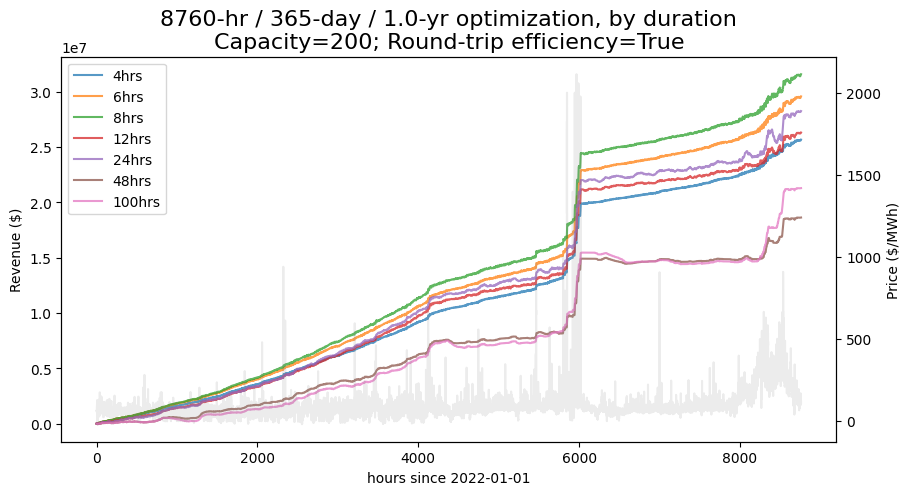

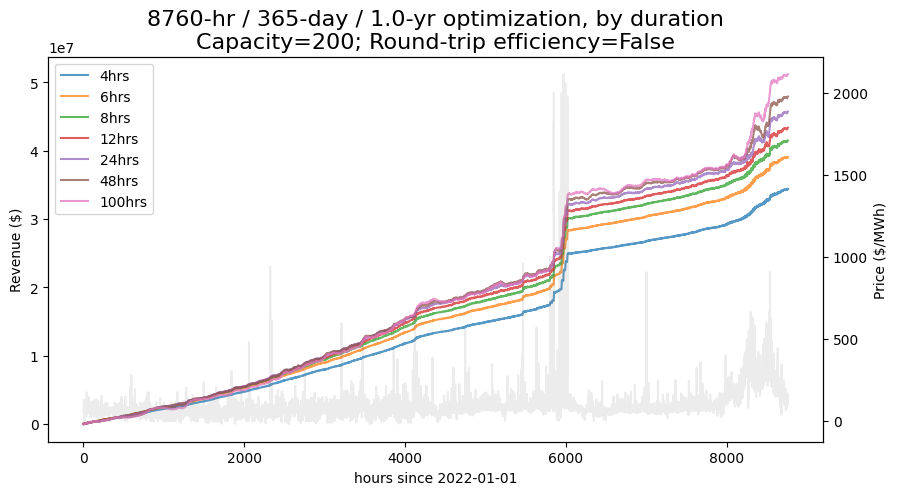

In [244]:
p = ptn
plot_optimal_rev_by_duration(p, dt_start, durations, capacity, True)
plot_optimal_rev_by_duration(p, dt_start, durations, capacity, False)

### 1.a.ii Moss landing hub

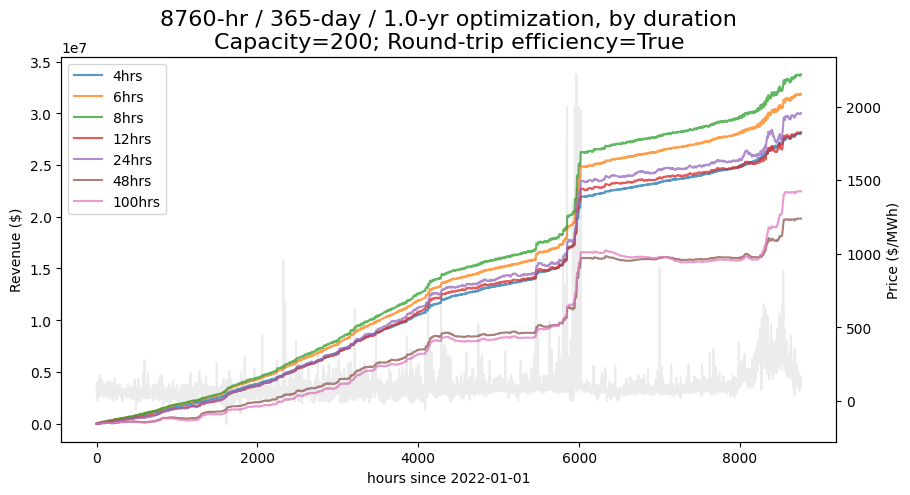

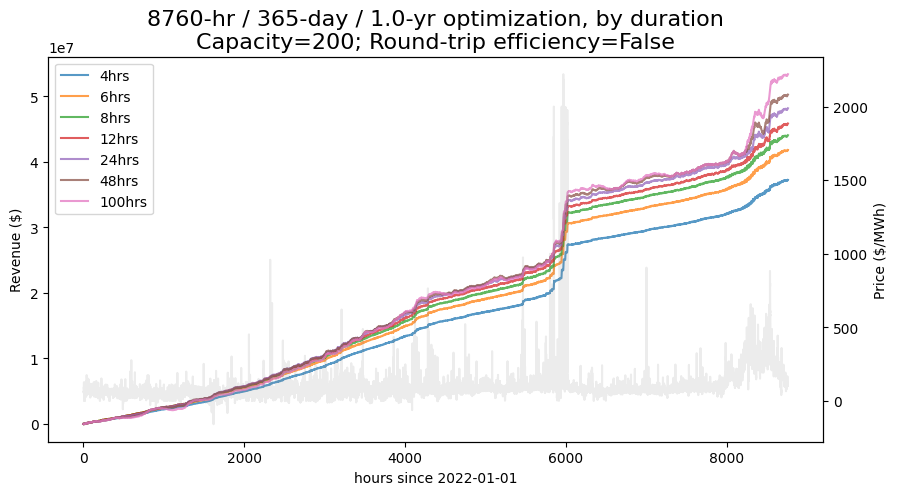

In [245]:
p = pm
plot_optimal_rev_by_duration(p, dt_start, durations, capacity, True)
plot_optimal_rev_by_duration(p, dt_start, durations, capacity, False)

### 1.a.iii Kern County hub

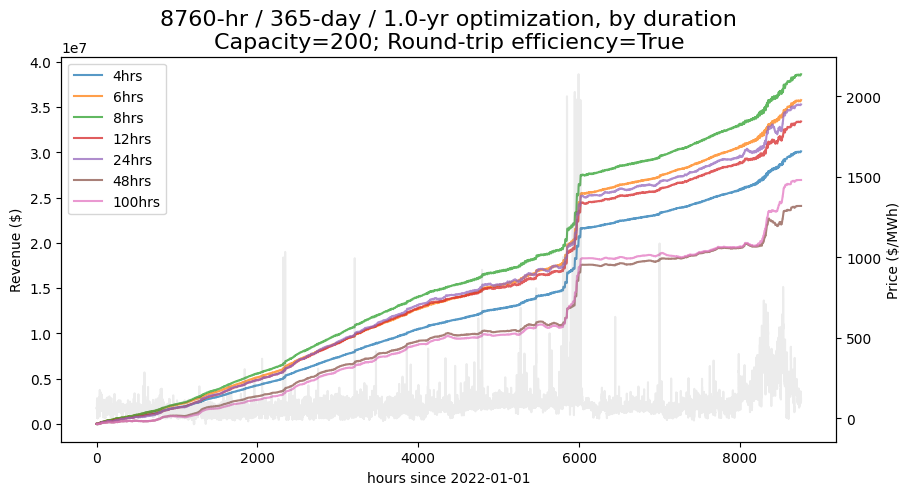

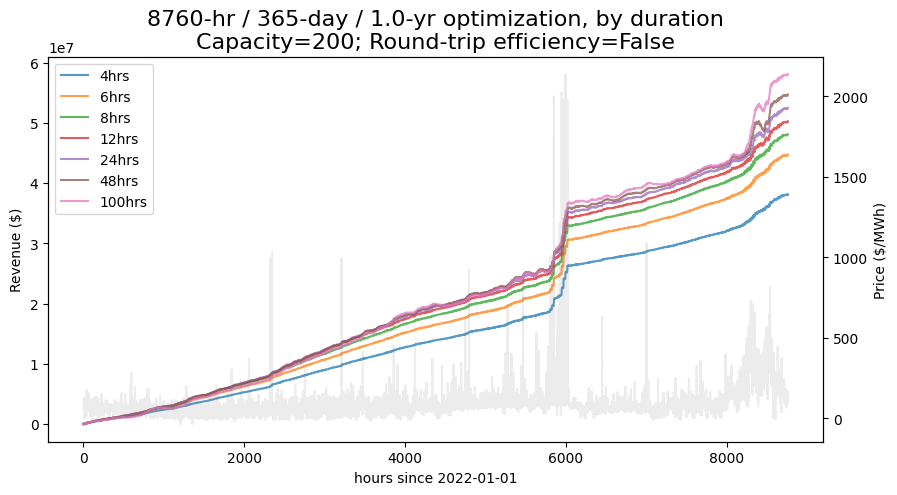

In [246]:
p = pk
plot_optimal_rev_by_duration(p, dt_start, durations, capacity, True)
plot_optimal_rev_by_duration(p, dt_start, durations, capacity, False)

## 1.b Battery schedule

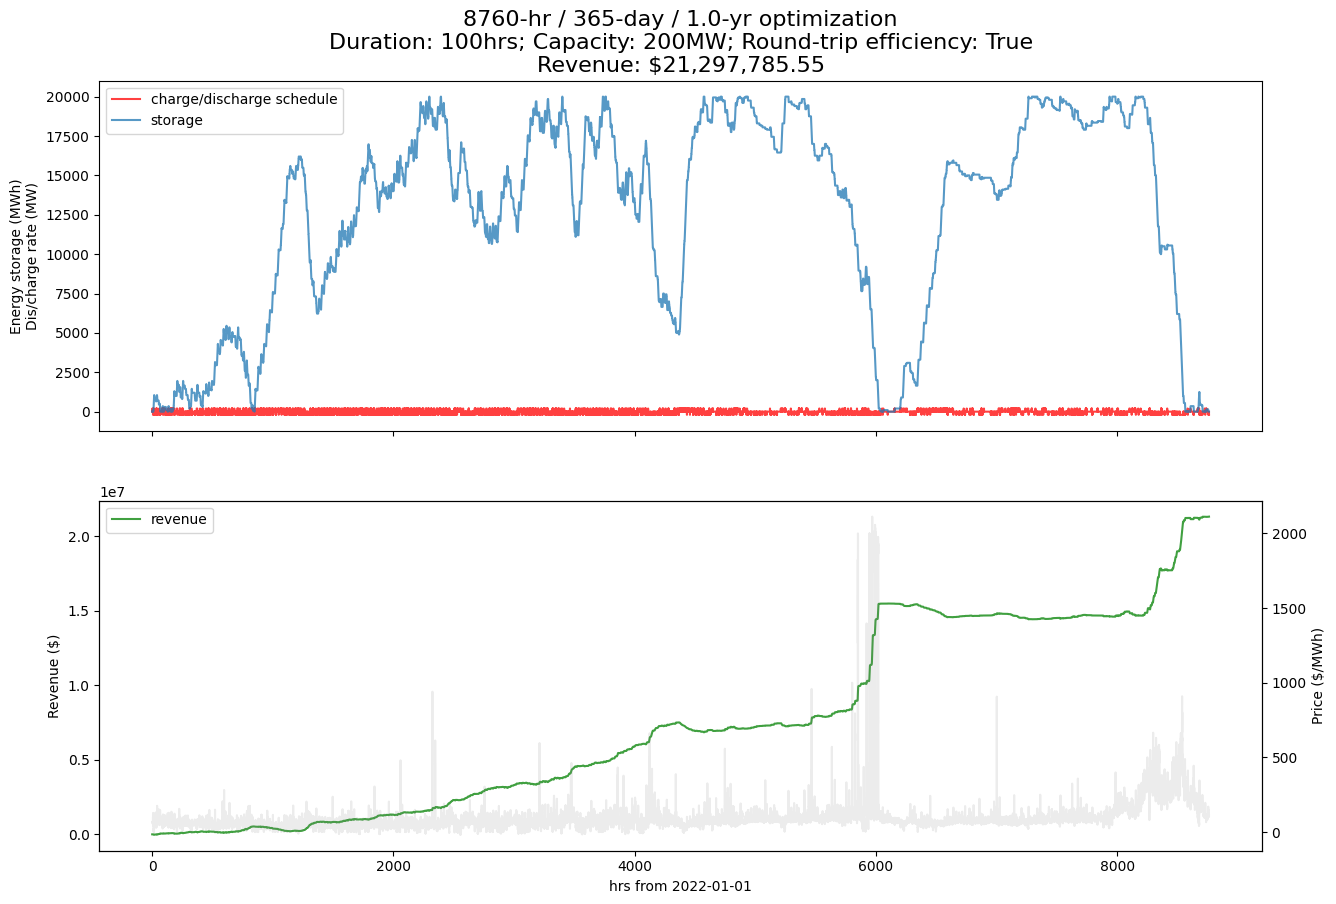

In [247]:
p = ptn
plot_optimal_performance(p, dt_start=dt_start, duration=100, capacity=capacity, use_efficiency=True)

## 1.c Look at relationship between revenue and duration

### One year (actual efficiencies)

In [27]:
p = ptn
t = len(p)
cap_step, dur_step = 60, 5
cap_max, dur_max = 300, 100
durations = np.arange(1, dur_max + dur_step, dur_step)
capacities = np.arange(cap_step, cap_max + cap_step, cap_step)
log_act = np.zeros((len(capacities), len(durations)))
for i, cap in enumerate(tqdm(capacities)):
    for j, dur in enumerate(durations):
        __, __, __, log_act[i, j] = get_optimal_battery_schedule(p, duration=dur, charge_capacity=cap, use_efficiency=True)
        

100%|█████████████████████████████████████████████| 5/5 [04:05<00:00, 49.07s/it]


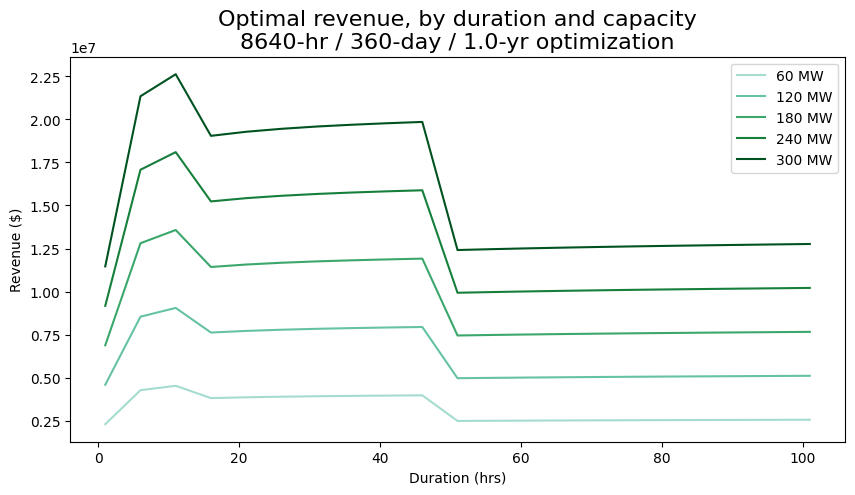

In [28]:
# plot
colors = plt.cm.BuGn(np.linspace(0.35,0.95,log_act.shape[0]))

fig = plt.figure(figsize=(10, 5))
for i, cap in enumerate(log_act):
    plt.plot(durations, cap, color=colors[i], label=f'{(i+1)*cap_step} MW')
    
plt.title(f'Optimal revenue, by duration and capacity\n{int(t/4)}-hr / {int(t/4/24)}-day / {np.round(t/4/24/365, 1)}-yr optimization')
plt.xlabel('Duration (hrs)')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()

### Check: do these lines compress to the same $/MW line?

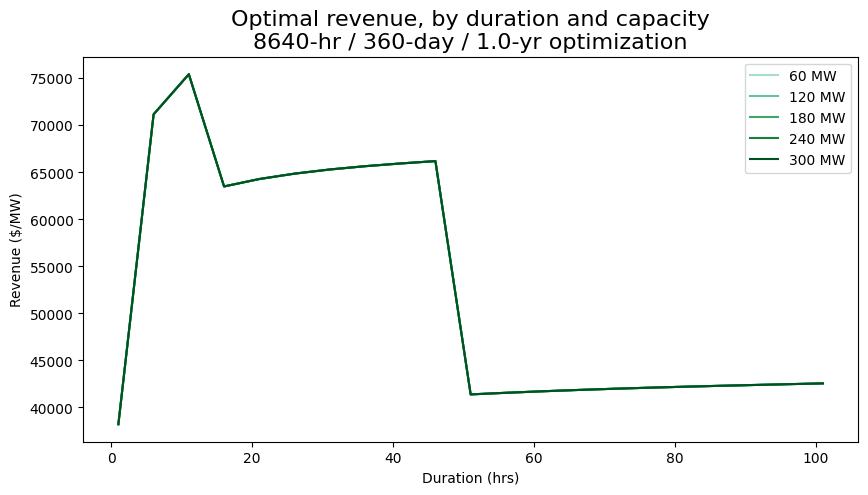

In [31]:
# plot
colors = plt.cm.BuGn(np.linspace(0.35,0.95,log.shape[0]))

fig = plt.figure(figsize=(10, 5))
for i, cap in enumerate(log_act):
    plt.plot(durations, cap/capacities[i], color=colors[i], label=f'{(i+1)*cap_step} MW')
    
plt.title(f'Optimal revenue, by duration and capacity\n{int(t/4)}-hr / {int(t/4/24)}-day / {np.round(t/4/24/365, 1)}-yr optimization')
plt.xlabel('Duration (hrs)')
plt.ylabel('Revenue ($/MW)')
plt.legend()
plt.show()

### One year (perfect efficiency)

In [21]:
log = np.zeros((len(capacities), len(durations)))
for i, cap in enumerate(tqdm(capacities)):
    for j, dur in enumerate(durations):
        __, __, __, log[i, j] = get_optimal_battery_schedule(p, duration=dur, charge_capacity=cap, use_efficiency=False)

100%|█████████████████████████████████████████████| 5/5 [03:25<00:00, 41.18s/it]


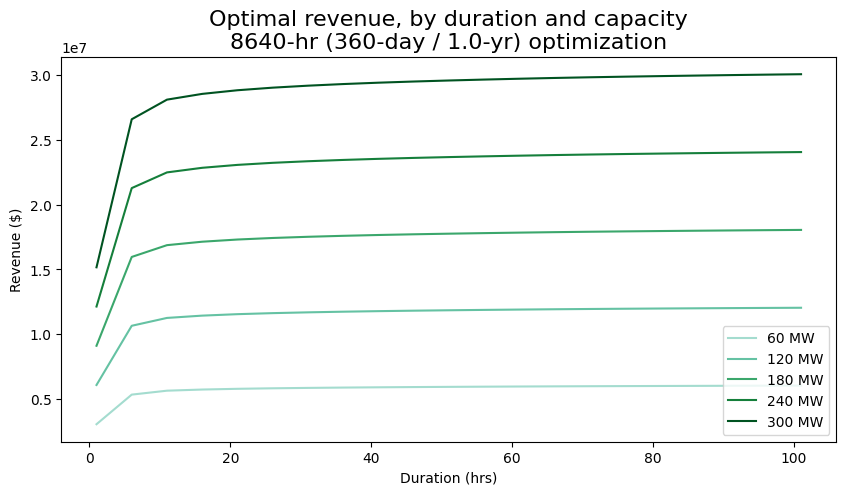

In [25]:
colors = plt.cm.BuGn(np.linspace(0.35,0.95,log.shape[0]))

fig = plt.figure(figsize=(10, 5))
for i, cap in enumerate(log):
    plt.plot(durations, cap, color=colors[i], label=f'{(i+1)*cap_step} MW')
    
plt.title(f'Optimal revenue, by duration and capacity\n{int(t/4)}-hr ({int(t/4/24)}-day / {np.round(t/4/24/365, 1)}-yr) optimization')
plt.xlabel('Duration (hrs)')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()

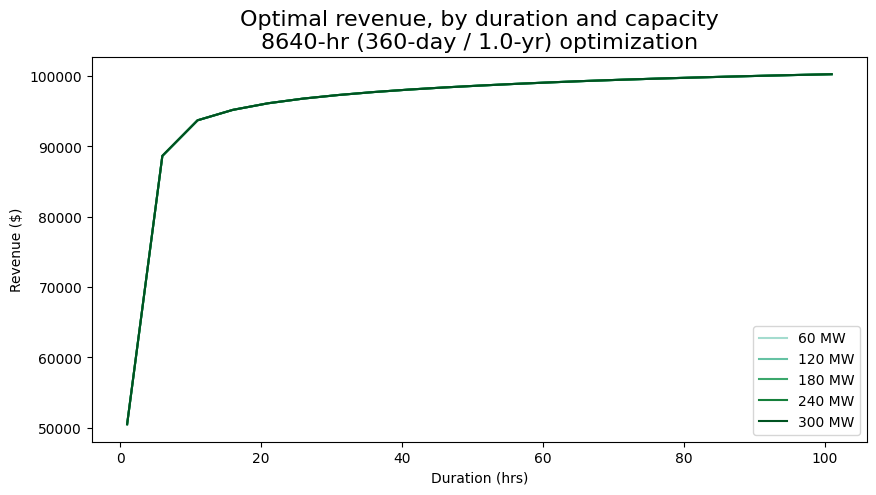

In [26]:
colors = plt.cm.BuGn(np.linspace(0.35,0.95,log.shape[0]))

fig = plt.figure(figsize=(10, 5))
for i, cap in enumerate(log):
    plt.plot(durations, cap/capacities[i], color=colors[i], label=f'{(i+1)*cap_step} MW')
    
plt.title(f'Optimal revenue, by duration and capacity\n{int(t/4)}-hr ({int(t/4/24)}-day / {np.round(t/4/24/365, 1)}-yr) optimization')
plt.xlabel('Duration (hrs)')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()

# 2. Are there periods when long-duration outperforms?

In [514]:
durations = [4, 6, 8, 12, 24, 48, 100]
capacity = 200
years = [2020, 2021, 2022]
# optimal revenue by month and by duration
node = nodes[3]

## 2.a Predict monthly difference between 6 and 100-hr, by price characteristics
* [finding] 6hr is consistently more profitable
* [finding] Higher IQR leads to smaller difference

In [508]:
labels = list(itertools.product(*[years, range(1, 13)]))
rev_summ = np.zeros((len(labels), len(durations)))
p_summ = np.zeros((len(labels), 8))
for i in tqdm(range(len(durations))):
    for j in range(len(years)):
        for k in range(12):
            p = data.lmp[(data.year == years[j]) & (data.month == k+1) & (data.location == node)].values
            p_summ[12*j+k, :] = pd.Series(p).describe()
            __, __, __, rev = get_optimal_battery_schedule(p, durations[i], capacity, storage_start=0., use_efficiency=True)
            rev_summ[12*j+k, i] = rev[-1]

100%|█████████████████████████████████████████████| 7/7 [00:31<00:00,  4.51s/it]


In [509]:
rev_summdf = pd.DataFrame(rev_summ, columns=[f'{d}hr' for d in durations])
p_summdf = pd.DataFrame(p_summ, columns=['count', 'mean', 'std', 'min', '25pctl', '50pctl', '75pctl', 'max'])
p_summdf['IQR'] = p_summdf['75pctl'] - p_summdf['25pctl']
p_summdf['range'] = p_summdf['max'] - p_summdf['min']
p_summdf = p_summdf.drop(columns=['count', '25pctl', '75pctl'])
lab_df = pd.DataFrame(labels, columns=['year', 'month'])
summ = pd.merge(lab_df, p_summdf, left_index=True, right_index=True).merge(rev_summdf, left_index=True, right_index=True)

In [537]:
y = rev_summdf['6hr'] - rev_summdf['100hr']
X = sm.add_constant(p_summdf.drop(columns=['max', 'range', '50pctl', 'min']))
ols = sm.OLS(endog=y, exog=X).fit(cov_type='HC0')
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     20.15
Date:                Sun, 26 Feb 2023   Prob (F-statistic):           1.61e-07
Time:                        17:28:34   Log-Likelihood:                -490.54
No. Observations:                  36   AIC:                             989.1
Df Residuals:                      32   BIC:                             995.4
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.407e+05   6.53e+04      3.683      0.0

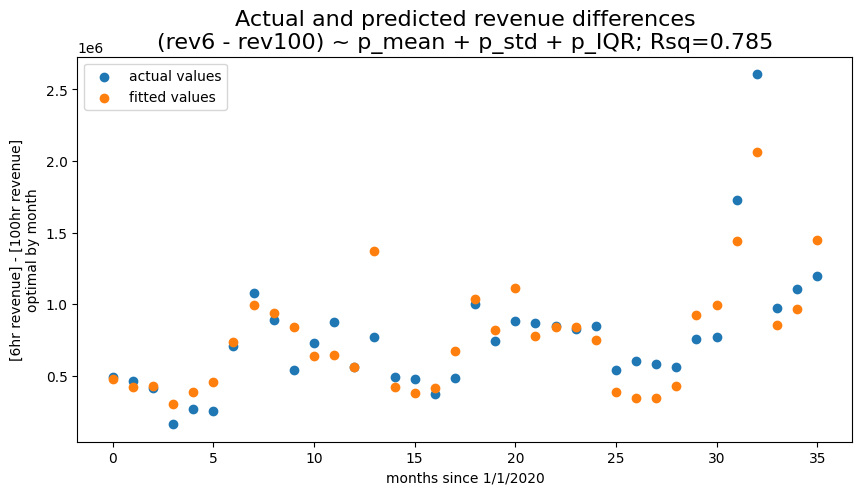

In [511]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y)), y, label='actual values')
plt.scatter(range(len(y)), ols.fittedvalues, label='fitted values')
plt.title(f'Actual and predicted revenue differences\n(rev6 - rev100) ~ p_mean + p_std + p_IQR; Rsq={np.round(ols.rsquared, 3)}')
plt.ylabel('[6hr revenue] - [100hr revenue]\noptimal by month')
plt.xlabel('months since 1/1/2020')
plt.legend()
plt.show()

## 2.b Look at performance in month with highest IQR

In [520]:
# find highest volatility months and other stand-out time periods
stat = 'IQR'
summ = data.loc[data.location == node].groupby(['month', 'year'])['lmp'].describe().reset_index()
summ['IQR'] = summ['75%'] - summ['25%']

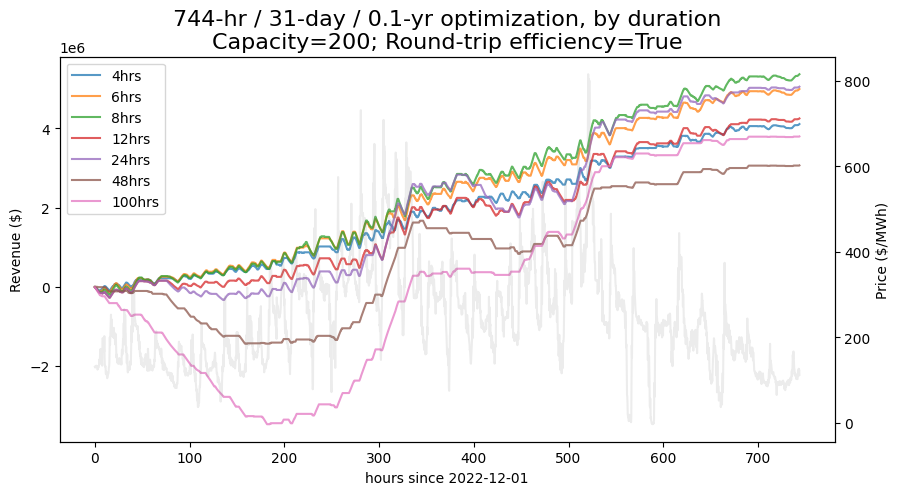

In [535]:
# visualize
max_values = summ.loc[summ[stat] == summ[stat].max()]
data_volatile = data.loc[(data.location == node) & 
                          (data.month == max_values.month.values[0]) & 
                          (data.year == max_values.year.values[0])]

dt_start = data_volatile.datetime.min().date()
p = data_volatile.lmp.values
plot_optimal_rev_by_duration(p, dt_start, durations, capacity, True)

# 3. Performance under limited (instead of 1-year) perfect foresight (7-day and 30-day) 
* [finding] Optimal revenue in any period occurs when the battery is fully drained at the end of the period, therefore optimization within 7-day or 30-day windows requires full discharge in that period
* [next step] We could consider adding value to carried charge within our objective function (perhaps using a capacity heuristic)

In [603]:
# settings
durations = [4, 6, 8, 12, 24, 48, 100]
capacity = 200

y = 2022
data_sub = data.loc[(data.location == node) & (data.year == y)]
dt_start = data_sub.datetime.min().date()

## 3.a 7-day perfect foresight

In [604]:
window_len = 4*24*7
periods = int(len(data_sub)/window_len)
revenue_log = np.zeros((len(durations), periods*window_len))

for i in tqdm(range(len(durations))):
    rev_last = 0
    e_last = 0
    revenue = np.array(())
    
    for period in range(periods):
        p = data_sub.lmp.values[window_len*period:window_len*(period+1)]

        e, c, d, rev = get_optimal_battery_schedule(p, durations[i], capacity, storage_start=e_last, use_efficiency=True)

        rev += rev_last
        rev_last = rev[-1]
        e_last = e[-1]

        revenue = np.concatenate([revenue, rev])
    
    revenue_log[i, :] = revenue

100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


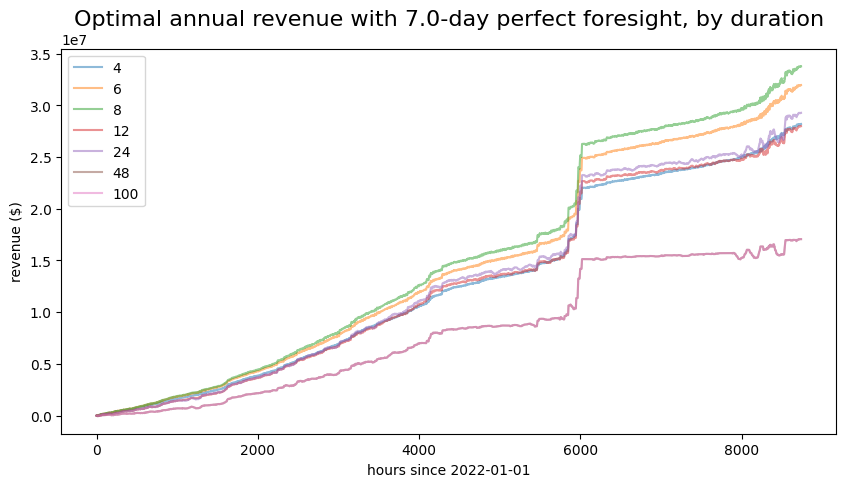

In [605]:
plt.figure(figsize=(10, 5))
for i, dur in enumerate(revenue_log):
    plt.plot(np.arange(window_len*periods)/4, dur, alpha=0.5, label=durations[i])
plt.title(f'Optimal annual revenue with {window_len/24/4}-day perfect foresight, by duration')
plt.xlabel(f'hours since {dt_start}')
plt.ylabel('revenue ($)')
plt.legend()
plt.show()

## 3.b 30-day perfect foresight

In [606]:
window_len = 4*24*30
periods = int(len(data_sub)/window_len)
revenue_log = np.zeros((len(durations), periods*window_len))

for i in tqdm(range(len(durations))):
    rev_last = 0
    e_last = 0
    revenue = np.array(())
    
    for period in range(periods):
        p = data_sub.lmp.values[window_len*period:window_len*(period+1)]

        e, c, d, rev = get_optimal_battery_schedule(p, durations[i], capacity, storage_start=e_last, use_efficiency=True)

        rev += rev_last
        rev_last = rev[-1]
        e_last = e[-1]

        revenue = np.concatenate([revenue, rev])
    
    revenue_log[i, :] = revenue

100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.19s/it]


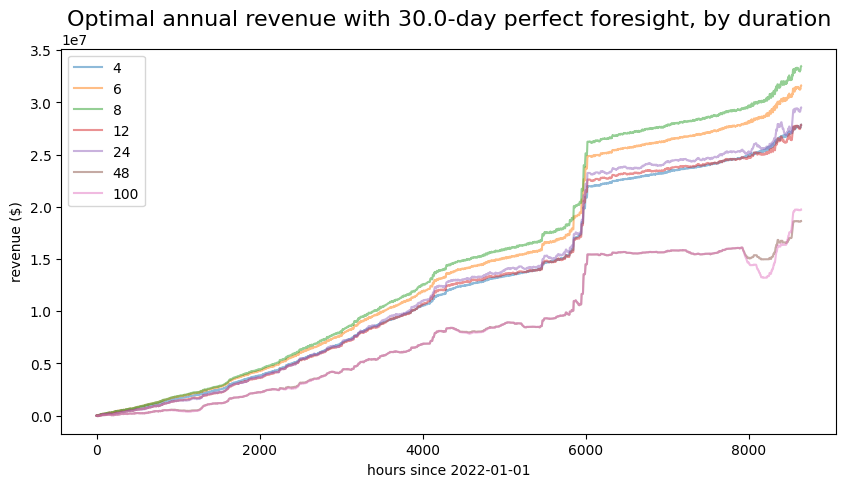

In [607]:
plt.figure(figsize=(10, 5))
for i, dur in enumerate(revenue_log):
    plt.plot(np.arange(window_len*periods)/4, dur, alpha=0.5, label=durations[i])
plt.title(f'Optimal annual revenue with {window_len/24/4}-day perfect foresight, by duration')
plt.xlabel(f'hours since {dt_start}')
plt.ylabel('revenue ($)')
plt.legend()
plt.show()